In [1]:
import itertools
import mne
import os
import random
import re
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import scipy.io as io
import tensorflow as tf


from datetime import datetime
from keras.wrappers.scikit_learn import KerasClassifier
from pywt import wavedec
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow import keras
from typing import List



2022-05-30 00:21:17.460177: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-30 00:21:17.582177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 00:21:17.582200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filename = "resources/dane_eeg.zip"
extract_dir = "resources/dane_eeg"
seizure_occ_file = "resources/dane_eeg/czasy_napadow.m"
healthy_dir = "resources/dane_eeg/zdrowi"
unhealthy_dir = "resources/dane_eeg/chorzy"
img_dir = "resources/dane_eeg/images/"
gd_path = "resources/gdsearch/"
plots_path = "resources/plots/"
measure_path = "resources/measures/"
models_path = "resources/models/"

# shutil.unpack_archive(filename, extract_dir)

In [3]:
def get_matlab_files(base_path): 
    mat_files_list = []
    filenames = {}

    for file in os.listdir(base_path):
        if file.endswith(".mat"):
            mat_files_list.append(base_path + "/" + file)
            
    for filename in mat_files_list:        
        filenames[filename.split('/')[-1].split('_')[0]] = filename
        
    return mat_files_list, filenames


healthy_paths, healthy_patients_dict = get_matlab_files(healthy_dir)
unhealthy_paths, unhealthy_patients_dict = get_matlab_files(unhealthy_dir)

In [4]:
def get_all_seizure_occurrences(file_path):
    all_occurrences = {}
    with open (file_path , 'r') as file:
        for line in file :
            line_number = int(re.search(r'{([0-9]+)}', line).group(1))
            occ_list = list(map(int, re.search(r'\[(.+?)]', line).group(1).split()))
            all_occurrences[line_number] = occ_list
    return all_occurrences


seizure_occurrences = get_all_seizure_occurrences(seizure_occ_file)

In [5]:
class Seizure:
    def __init__ (self, id, filename, samples, seizure_occurrences=None, frequency=100, channels=16) -> None :
        super (). __init__ ()
        self.id = id
        self.filename = filename
        self.samples = samples
        self.seizure_occurrences = seizure_occurrences
        self.frequency = frequency
        self.channels = channels

In [6]:
def get_patients_lists(healthy_people_dict, unhealthy_people_dict, seizure_occurrences):
    healthy_patients = []
    unhealthy_patients = []
    
    for id, path in healthy_people_dict.items():
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        healthy_patients.append(Seizure(id, filename, samples))
 
    for id, path in unhealthy_people_dict.items():
        seizure_occ = seizure_occurrences[int(id)]
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        unhealthy_patients.append(Seizure(id, filename, samples, seizure_occurrences=seizure_occ))

    return healthy_patients, unhealthy_patients


healthy_list, unhealthy_list = get_patients_lists(healthy_patients_dict, unhealthy_patients_dict, seizure_occurrences)

In [8]:
# def saveToPng(figure, filename, img_dir, seizure_time):
#     base_filename = os.path.splitext(filename)[0]
#     dir_name = img_dir + base_filename
#     if not os.path.exists(dir_name):
#         os. makedirs(dir_name)
#     figure.savefig(dir_name + '/' + base_filename + str(seizure_time) + '.png')


# def plot_all_attacks(unhealthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def create_annotations(occurrences):
#         events = [x for x in occurrences ]
#         return mne.Annotations(onset=events, duration=2, description=['seizure ' + str(x) for x in occurrences])

#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)
            
# def plot_healthy(healthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)

In [9]:
# plot_all_attacks(unhealthy_list, save_to_png = True, img_dir=img_dir)
# list(map(str,range(1,17))) 

In [10]:
# def plot_seizures_of_patient(unhealthy_people, patient_nr, channels_no =1):
#     patient = next((x for x in unhealthy_people if x.id == str(patient_nr)), 0)
#     info = mne.create_info(ch_names = list(map(str,range(1,17))), sfreq = 100, ch_types ='eeg')
#     raw = mne.io.RawArray(np.transpose(patient.samples), info)
#     annot = mne.Annotations(onset = patient.seizure_matches, duration = 2, description = patient.seizure_matches) 
#     raw.set_annotations(annot)
#     plot_kwargs = {
#         'scalings': dict(eeg=30),
#         'highpass': 1,
#         'lowpass': 40,
#         'n_channels': channels_no,
#         'duration': 10,
#     }

#     for seizure in patient.seizure_occurences:
#         raw.plot(**plot_kwargs, start = seizure - 2)

In [7]:
for patient in healthy_list:
    patient.samples = np.delete(patient.samples, -1, axis=1)

In [8]:
seizure_time = 100

healthy_epochs = []
for healthy_patient in healthy_list:
    samples = healthy_patient.samples
    for i in range(0, samples.shape[0] - 100, seizure_time):
        chunk = samples[i:i + seizure_time]
        healthy_epochs.append(('healthy', chunk))


unhealthy_epochs = []
for unhealthy_patient in unhealthy_list:
    samples = unhealthy_patient.samples
    for seizure_time in unhealthy_patient.seizure_occurrences:
        seizure_start = seizure_time * 100
        chunk = samples[seizure_time:seizure_time + seizure_time]
        unhealthy_epochs.append(('unhealthy', chunk))


chunks_healthy_from_unhealthy = []
for unhealthy_patient in unhealthy_list:
    samples = unhealthy_patient.samples
    occurrences = unhealthy_patient.seizure_occurrences
    indices = [i * 100 for i in occurrences]

    # divide by seizure matches
    chunks = np.split(samples, indices)
    chunks_healthy = [chunks[0][: -(2*seizure_time)]]

     # remove 2 seconds of potential seizure from each chunk
    for element in chunks[1:]:
        chunks_healthy.append(element[(2*seizure_time):])

     # split each chunk for healthy waves
    for e in chunks_healthy:
        for i in range(0, e.shape [0] - 100, seizure_time):
            chunk = e[i:i + seizure_time]
            chunks_healthy_from_unhealthy.append(('healthy', chunk))            

In [9]:
def wavelet_decompose_channels(data, level):
    data.columns.name ='channel'
    data_t = data.transpose()

    coeffs_list = wavedec(data_t.values, wavelet ='db4', level = level)

    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[ -1]))

    # reverse the names
    names = names[:: -1]
    wavelets = pd.DataFrame()

    for i, array in enumerate(coeffs_list):
        lvl_df = pd.DataFrame(array)
        lvl_df.index = data.columns
        lvl_df['level'] = names[i]
        lvl_df = lvl_df.set_index('level', append = True)
        lvl_df = lvl_df.T
        wavelets = pd.concat([ wavelets, lvl_df ], axis=1, sort = True)

    wavelets = wavelets.sort_values(['channel','level'], axis=1)

    to_be_dropped = [x for x in list(wavelets.columns.levels[1]) if not re.compile('D').match(x)]
    decom_wavelets = wavelets.drop(to_be_dropped, axis=1, level ='level')

    decom_wavelets.index.name ='sample'

    return decom_wavelets


class Feature:
    def __init__(self, max, min, mean, std, mean_abs, var) -> None:
        super().__init__()
        self.max = max
        self.min = min
        self.mean = mean
        self.std = std
        self.mean_abs = mean_abs
        self.var = var

    def getall(self):
        import itertools
        return list(itertools.chain(self.max, self.min, self.mean, self.std, self.mean_abs, self.var))

all_label_features = []


def get_features(data):
    max_data = data.max().to_numpy()
    min_data = data.min().to_numpy()
    mean_data = data.mean().to_numpy()
    std_data = data.std().to_numpy()
    mean_abs_data = data.abs().mean().to_numpy()
    var_data = data.var().to_numpy()

    return Feature(max_data, min_data, mean_data, std_data, mean_abs_data, var_data)

def convert_y_to_number(str):
    return 1.0 if str == 'unhealthy' else 0.0

In [10]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Dropout, AveragePooling1D, GlobalAveragePooling1D, Dense
from keras.optimizers import Adam

def model_1d_1b(kernel_size, n_timesteps, n_features, n_outputs, learning_rate=0.001):
    model_1d_1 = Sequential()
    model_1d_1.add(Conv1D(filters=32, activation='relu', kernel_size=kernel_size, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d_1.add(Conv1D(filters=32, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(MaxPool1D(pool_size=2, strides=2))
    model_1d_1.add(Conv1D(filters=64, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(Conv1D(filters=64, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(MaxPool1D(pool_size=2, strides=2))
    model_1d_1.add(Dropout(0.5))
    model_1d_1.add(Conv1D(filters=128, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(Conv1D(filters=128, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(AveragePooling1D(pool_size=2, strides=2))
    model_1d_1.add(Dropout(0.5))
    model_1d_1.add(Conv1D(filters=256, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(Conv1D(filters=256, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(AveragePooling1D(pool_size=2, strides=2))
    model_1d_1.add(Conv1D(filters=256, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(Conv1D(filters=256, activation='relu', kernel_size=kernel_size, strides=1))
    model_1d_1.add(GlobalAveragePooling1D())
    model_1d_1.add(Dense(n_outputs, activation="sigmoid"))
    model_1d_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy']) 
    return model_1d_1

def model_1d_1(kernel_size, n_timesteps, n_features, n_outputs):
    model_1d_1 = keras.models.Sequential()
    model_1d_1.add(keras.layers.Conv1D(filters=64, kernel_size=kernel_size, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d_1.add(keras.layers.BatchNormalization())
    model_1d_1.add(keras.layers.LeakyReLU())
    model_1d_1.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_1.add(keras.layers.Conv1D(filters=128, kernel_size=kernel_size, strides=1))
    model_1d_1.add(keras.layers.LeakyReLU())
    model_1d_1.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_1.add(keras.layers.Dropout(0.5))
    model_1d_1.add(keras.layers.Conv1D(filters=256, kernel_size=kernel_size, strides=1))
    model_1d_1.add(keras.layers.LeakyReLU())
    model_1d_1.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_1.add(keras.layers.Dropout(0.5))
    model_1d_1.add(keras.layers.Conv1D(filters=512, kernel_size=kernel_size, strides=1))
    model_1d_1.add(keras.layers.LeakyReLU())
    model_1d_1.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_1.add(keras.layers.Conv1D(filters=1024, kernel_size=kernel_size, strides=1))
    model_1d_1.add(keras.layers.LeakyReLU())
    model_1d_1.add(keras.layers.GlobalAveragePooling1D())
    model_1d_1.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    model_1d_1.compile('sgd', loss='binary_crossentropy', metrics=['accuracy']) 
    return model_1d_1

def model_1d_1a(kernel_size, n_timesteps, n_features, n_outputs):
    model_1d_1a = keras.models.Sequential()
    model_1d_1a.add(keras.layers.Conv1D(filters=64, kernel_size=kernel_size, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d_1a.add(keras.layers.BatchNormalization())
    model_1d_1a.add(keras.layers.LeakyReLU())
    model_1d_1a.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_1a.add(keras.layers.Conv1D(filters=128, kernel_size=kernel_size, strides=1))
    model_1d_1a.add(keras.layers.LeakyReLU())
    model_1d_1a.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_1a.add(keras.layers.Dropout(0.5))
    model_1d_1a.add(keras.layers.Conv1D(filters=256, kernel_size=kernel_size, strides=1))
    model_1d_1a.add(keras.layers.LeakyReLU())
    model_1d_1a.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_1a.add(keras.layers.Dropout(0.5))
    model_1d_1a.add(keras.layers.Conv1D(filters=512, kernel_size=kernel_size, strides=1))
    model_1d_1a.add(keras.layers.LeakyReLU())
    model_1d_1a.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_1a.add(keras.layers.Conv1D(filters=1024, kernel_size=kernel_size, strides=1))
    model_1d_1a.add(keras.layers.LeakyReLU())
    model_1d_1a.add(keras.layers.GlobalAveragePooling1D())
    model_1d_1a.add(keras.layers.Dense(100, activation='relu'))
    model_1d_1a.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    model_1d_1a.compile('sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model_1d_1a


def model_1d_2(kernel_size, n_timesteps, n_features, n_outputs):
    model_1d_2 = keras.models.Sequential()
    model_1d_2.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d_2.add(keras.layers.BatchNormalization())
    model_1d_2.add(keras.layers.LeakyReLU())
    model_1d_2.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_2.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2.add(keras.layers.LeakyReLU())
    model_1d_2.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_2.add(keras.layers.Dropout(0.5))
    model_1d_2.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2.add(keras.layers.LeakyReLU())
    model_1d_2.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_2.add(keras.layers.Dropout(0.5))
    model_1d_2.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2.add(keras.layers.LeakyReLU())
    model_1d_2.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_2.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2.add(keras.layers.LeakyReLU())
    model_1d_2.add(keras.layers.GlobalAveragePooling1D())
    model_1d_2.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    return model_1d_2


def model_1d_2a(kernel_size, n_timesteps, n_features, n_outputs):
    model_1d_2a = keras.models.Sequential()
    model_1d_2a.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d_2a.add(keras.layers.BatchNormalization())
    model_1d_2a.add(keras.layers.LeakyReLU())
    model_1d_2a.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_2a.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2a.add(keras.layers.LeakyReLU())
    model_1d_2a.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d_2a.add(keras.layers.Dropout(0.5))
    model_1d_2a.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2a.add(keras.layers.LeakyReLU())
    model_1d_2a.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_2a.add(keras.layers.Dropout(0.5))
    model_1d_2a.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2a.add(keras.layers.LeakyReLU())
    model_1d_2a.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d_2a.add(keras.layers.Conv1D(filters=5, kernel_size=kernel_size, strides=1))
    model_1d_2a.add(keras.layers.LeakyReLU())
    model_1d_2a.add(keras.layers.GlobalAveragePooling1D())
    model_1d_2a.add(keras.layers.Dense(100, activation='relu'))
    model_1d_2a.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    return model_1d_2a


def model_1d_3(kernel_size, n_timesteps, n_features, n_outputs):
    model_1d_3 = keras.models.Sequential()
    model_1d_3.add(keras.layers.Conv1D(filters=64, kernel_size=kernel_size, activation='relu', input_shape=(n_timesteps,n_features)))
    model_1d_3.add(keras.layers.Conv1D(filters=64, kernel_size=kernel_size, activation='relu'))
    model_1d_3.add(keras.layers.Dropout(0.5))
    model_1d_3.add(keras.layers.MaxPooling1D(pool_size=2))
    model_1d_3.add(keras.layers.Flatten())
    model_1d_3.add(keras.layers.Dense(100, activation='relu'))
    model_1d_3.add(keras.layers.Dense(n_outputs, activation='sigmoid'))
    return model_1d_3





In [11]:
r_state = np.random.RandomState()

# start_transforming = time.time()
          
all_label_features = []
healthy_size = 1000
# healthy_from_unhealthy_size = healthy_size * ((len(chunks_healthy_from_unhealthy) / len(healthy_epochs)))
true_healthy = random.sample(healthy_epochs, healthy_size)
# healthy_chunks_from_unhealthy = random.sample(chunks_healthy_from_unhealthy, int(healthy_from_unhealthy_size))
all_epochs = true_healthy + unhealthy_epochs

X = []
y = []

for epoch in all_epochs:
    y.append(convert_y_to_number(epoch[0]))
    X.append(get_features(wavelet_decompose_channels(pd.DataFrame(epoch[1]), level=4)).getall())


# X = np.array(list(x[1].getall() for x in all_label_features)) # data
# y = np.array(list(convert_y_to_number(x[0]) for x in all_label_features)) # labels

# X = list(x[1].getall() for x in all_label_features) # data
# y = list(convert_y_to_number(x[0]) for x in all_label_features) # labels


X_r = np.array(X)
y_r = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.4, random_state=r_state, shuffle=True)

n_timesteps = X_r.shape[1]
n_features = 1
n_outputs = 1

end_transforming = time.time()
elapsed_transforming_time = end_transforming - start_transforming
print("Elapsed time for processing: %s" % str(elapsed_transforming_time))

/home/dominik_zawrotny/ml/ml_venv/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [47]:
# batch_size = 60
# kernel_size = 5
# n_epochs = 30
# verbose = 1
# time_identifier = datetime.today().strftime('%Y%m%d%H%M%S')
# identifier = "model_1d_1_batch_%s_epochs_%s_kernel_%s" %(batch_size, n_epochs, kernel_size)

# start_training = time.time()

# model = model_1d_1(kernel_size, n_timesteps, n_features, n_outputs)

# model.summary()

# history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)
# _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

# if not os.path.exists(plots_path):
#     os.makedirs(plots_path)


# pd.DataFrame(history.history).plot(figsize=(8, 10))
# plt.grid(True)
# plt.gca().set_ylim(0, 1)
# plt.savefig(plots_path + '/' + time_identifier + '_plot_' + identifier + '.png')

# end_training = time.time()
# elapsed_training_time = end_training - start_training

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 382, 32)           128       
                                                                 
 conv1d_51 (Conv1D)          (None, 380, 32)           3104      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 190, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_52 (Conv1D)          (None, 188, 64)           6208      
                                                                 
 conv1d_53 (Conv1D)          (None, 186, 64)           12352     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 93, 64)           0         
 g1D)                                                 

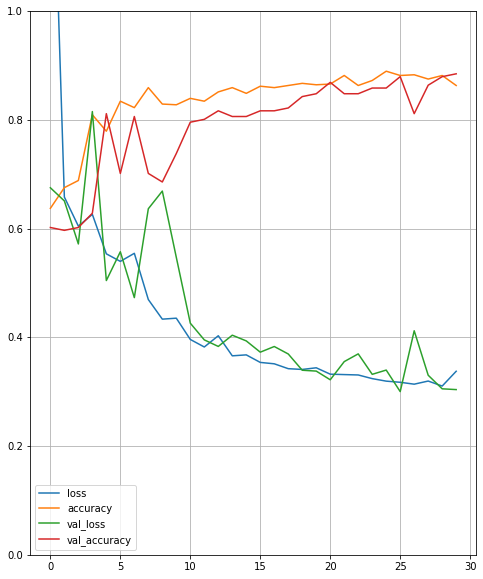

In [22]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=models_path + '/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
#     keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

batch_size = 60
kernel_size = 3
n_epochs = 30
verbose = 1
time_identifier = datetime.today().strftime('%Y%m%d%H%M%S')
identifier = "model_1d_1_batch_%s_epochs_%s_kernel_%s" %(batch_size, n_epochs, kernel_size)

start_training = time.time()

model = model_1d_1b(kernel_size, n_timesteps, n_features, n_outputs, 0.001)

model.summary()

# history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)
# _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)


history = model.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

if not os.path.exists(plots_path):
    os.makedirs(plots_path)


pd.DataFrame(history.history).plot(figsize=(8, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig(plots_path + '/' + time_identifier + '_plot_' + identifier + '.png')

end_training = time.time()
elapsed_training_time = end_training - start_training




20/20 [==============================] - 0s 13ms/step
CONFUSION MATRIX 
[[193  49]
 [ 27 367]]

True positive:  193
False positive:  49
False negative:  27
True negative:  367

Accuracy: 88.0503%
Sensitivity: 87.7273%
Specificity: 88.2212%
Precision: 79.7521%
F1 score [ NOT SEIZURE, SEIZURE ] [0.90617284 0.83549784]



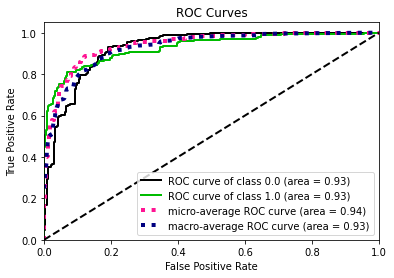

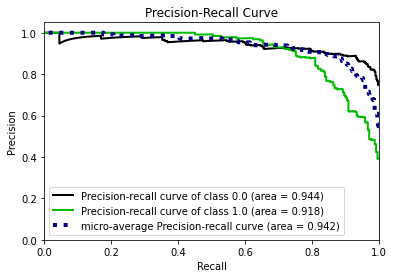

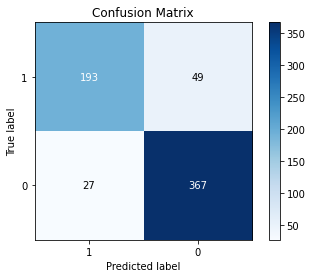

In [25]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix

def predict_prob(number):
    return [1-number[0], number[0]]


def return_prob(number):
    return 1.0 if number > 0.5 else 0.0

y_pred = model.predict(X_test)
y_pred_prob = np.array(list(predict_prob(x) for x in y_pred)) # data
y_pred_r = np.array(list(return_prob(x) for x in y_pred)) # data

# ROC CURVE
roc_plot = skplt.metrics.plot_roc(y_test, y_pred_prob)

# PRECISION RECALL
prec_recall_plot = skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

print("CONFUSION MATRIX ")
conf_matrix_plot = skplt.metrics.plot_confusion_matrix(y_test, y_pred_r, labels=[1, 0])

conf_matrix = confusion_matrix(y_test, y_pred_r, labels=[1, 0])

print(conf_matrix)

true_positive = conf_matrix[0][0]
false_positive = conf_matrix[0][1]
false_negative = conf_matrix[1][0]
true_negative = conf_matrix[1][1]

print("\nTrue positive: ", true_positive)
print("False positive: ", false_positive)
print("False negative: ", false_negative)
print("True negative: ", true_negative)

acc_score = accuracy_score(y_test, y_pred_r)
acc_str = f"\nAccuracy: %.4f%%"%(acc_score * 100)
print(acc_str)

def safe_division(divident, divisor):
    return divident / divisor if divisor != 0 else 0

sensitivity = safe_division(true_positive, (true_positive + false_negative))
sensitivity_str = f"Sensitivity: %.4f%%"%(sensitivity * 100)
print(sensitivity_str)

specifity = safe_division(true_negative, (true_negative + false_positive))
specifity_str = f"Specificity: %.4f%%"%(specifity * 100)
print(specifity_str)

precision = safe_division(true_positive, (true_positive + false_positive))
precision_str = f"Precision: %.4f%%"%(precision * 100)
print(precision_str)

fscore = f1_score(y_test, y_pred_r, average = None)
f1score_str = "F1 score [ NOT SEIZURE, SEIZURE ] "+ str(fscore) + "\n"
print(f1score_str)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix


classifiers = [
    ("KNN-1_nn-70_leaf_size", KNeighborsClassifier(1, leaf_size=70)),
    ("KNN-2_nn-30_leaf_size", KNeighborsClassifier(2, leaf_size=30)),
    ("KNN-12_nn-70_leaf_size", KNeighborsClassifier(12, leaf_size=70)),
    ("SVM_rbf1", SVC(random_state=r_state, kernel="rbf", C=1, degree=2, probability=True)),
    ("SVM_rbf2", SVC(random_state=r_state, kernel="rbf", C=10, degree=2, probability=True)),
    ("SVM_rbf3", SVC(random_state=r_state, kernel="rbf", C=100, degree=2, probability=True)),
    ("Naive_Bayes-Gaussian", GaussianNB()),    
]


def savePlot(figure, class_name, metric_type):
    figure.savefig(measure_path + '/' + class_name + '_' + metric_type +'.png')


def score_eval(classifier, classifier_name, X_tr, y_tr, X_te, y_te, save_metrics = True):
    print(f"Scores for %s\n"%  classifier_name)

    classifier.fit(X_tr, y_tr)
    y_pred_prob = classifier.predict_proba(X_te)

    # ROC CURVE
    roc_plot = skplt.metrics.plot_roc(y_te, y_pred_prob)

    # PRECISION RECALL
    prec_recall_plot = skplt.metrics.plot_precision_recall(y_te, y_pred_prob)

    print("CONFUSION MATRIX ")
    y_pred_normal = classifier.predict(X_te)

    conf_matrix_plot = skplt.metrics.plot_confusion_matrix(y_te, y_pred_normal, labels=[1, 0])

    conf_matrix = confusion_matrix(y_te, y_pred_normal, labels=[1, 0])

    print(conf_matrix)
    
    true_positive = conf_matrix[0][0]
    false_positive = conf_matrix[0][1]
    false_negative = conf_matrix[1][0]
    true_negative = conf_matrix[1][1]
    
    print("\nTrue positive: ", true_positive)
    print("False positive: ", false_positive)
    print("False negative: ", false_negative)
    print("True negative: ", true_negative)

    acc_score = accuracy_score(y_te, y_pred_normal)
    acc_str = f"\nAccuracy: %.4f%%"%(acc_score * 100)
    print(acc_str)
    
    def safe_division(divident, divisor):
        return divident / divisor if divisor != 0 else 0
    
    sensitivity = safe_division(true_positive, (true_positive + false_negative))
    sensitivity_str = f"Sensitivity: %.4f%%"%(sensitivity * 100)
    print(sensitivity_str)

    specifity = safe_division(true_negative, (true_negative + false_positive))
    specifity_str = f"Specificity: %.4f%%"%(specifity * 100)
    print(specifity_str)

    precision = safe_division(true_positive, (true_positive + false_positive))
    precision_str = f"Precision: %.4f%%"%(precision * 100)
    print(precision_str)
    
    fscore = f1_score(y_te, y_pred_normal, average = None)
    f1score_str = "F1 score [ NOT SEIZURE, SEIZURE ] "+ str(fscore) + "\n"
    print(f1score_str)

    if save_metrics:
        savePlot(roc_plot.get_figure(),  classifier_name, "roc")
        savePlot(prec_recall_plot.get_figure(),  classifier_name, "precision")
        savePlot(conf_matrix_plot.get_figure(),  classifier_name, "conf-matrix")
        lines = [ acc_str, f1score_str, sensitivity_str, specifity_str, precision_str ]
        with open(measure_path + '/' +  classifier_name +'-metrics.txt', 'w') as f:
            f.write('\n'.join(lines))
            

Scores for KNN-1_nn-70_leaf_size

CONFUSION MATRIX 
[[136  20]
 [ 20 221]]

True positive:  136
False positive:  20
False negative:  20
True negative:  221

Accuracy: 89.9244%
Sensitivity: 87.1795%
Specificity: 91.7012%
Precision: 87.1795%
F1 score [ NOT SEIZURE, SEIZURE ] [0.91701245 0.87179487]

Scores for KNN-2_nn-30_leaf_size

CONFUSION MATRIX 
[[120  36]
 [  8 233]]

True positive:  120
False positive:  36
False negative:  8
True negative:  233

Accuracy: 88.9169%
Sensitivity: 93.7500%
Specificity: 86.6171%
Precision: 76.9231%
F1 score [ NOT SEIZURE, SEIZURE ] [0.91372549 0.84507042]

Scores for KNN-12_nn-70_leaf_size

CONFUSION MATRIX 
[[122  34]
 [ 16 225]]

True positive:  122
False positive:  34
False negative:  16
True negative:  225

Accuracy: 87.4055%
Sensitivity: 88.4058%
Specificity: 86.8726%
Precision: 78.2051%
F1 score [ NOT SEIZURE, SEIZURE ] [0.9        0.82993197]

Scores for SVM_rbf1

CONFUSION MATRIX 
[[107  49]
 [ 13 228]]

True positive:  107
False positive:  49


/home/dominik_zawrotny/ml/ml_venv/lib/python3.7/site-packages/scikitplot/metrics.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize)


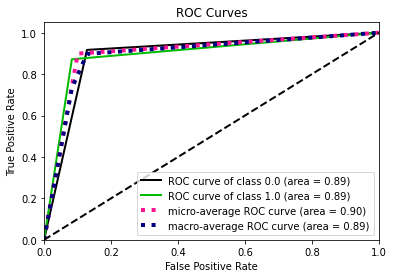

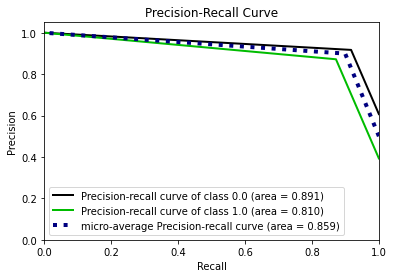

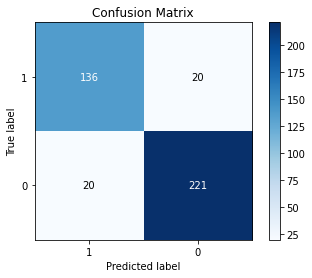

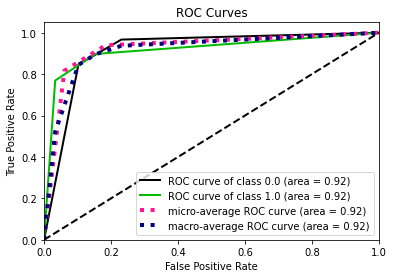

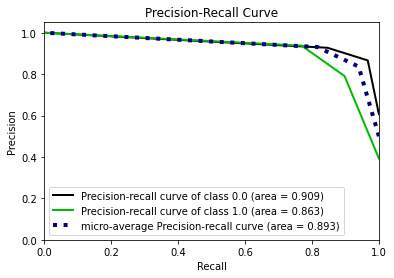

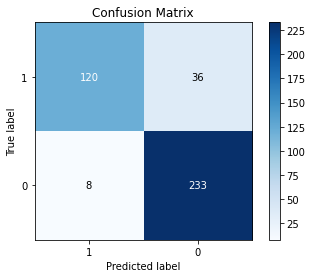

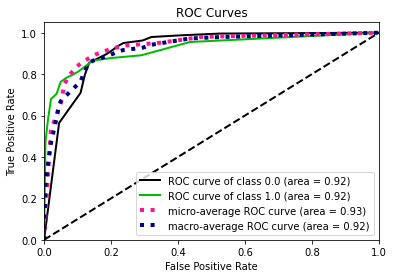

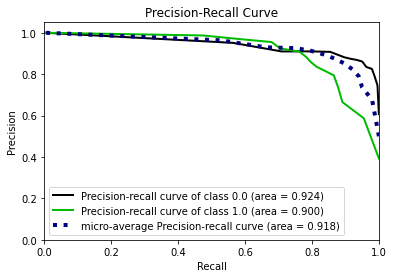

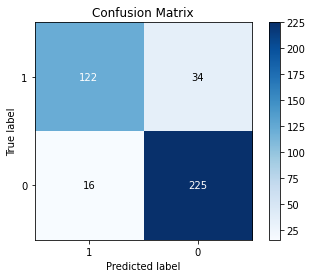

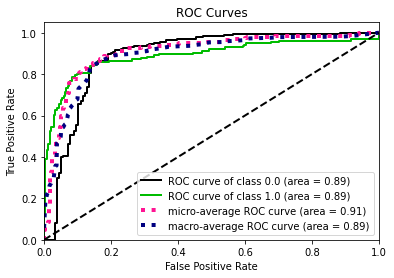

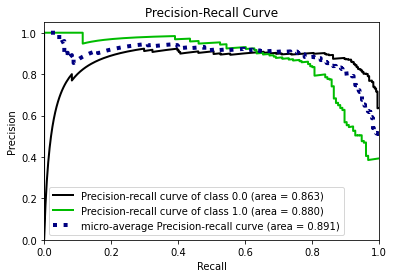

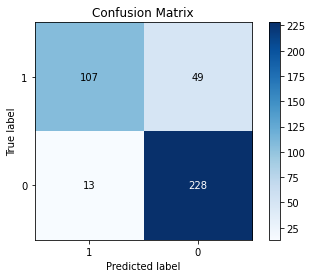

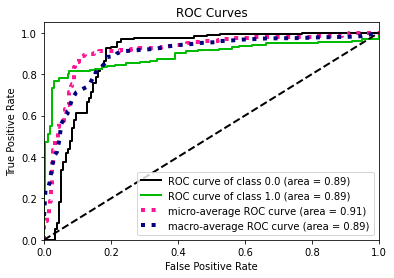

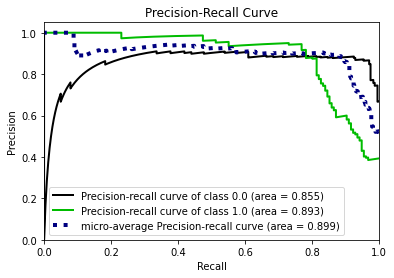

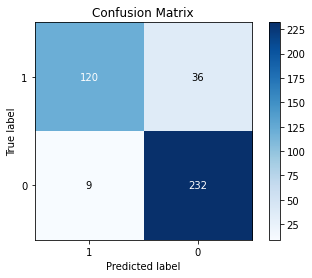

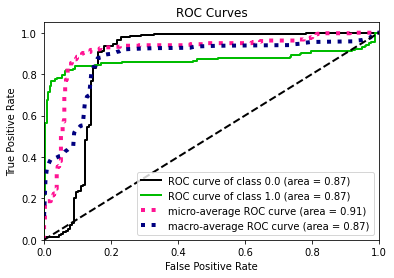

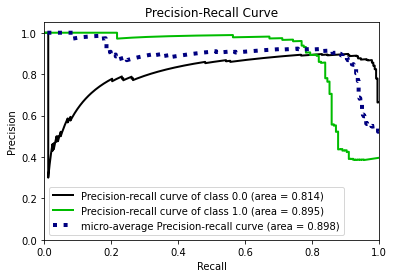

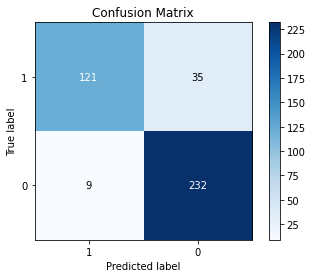

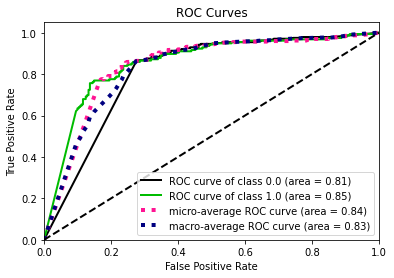

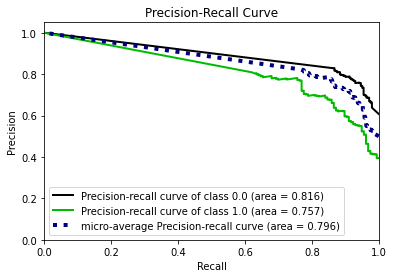

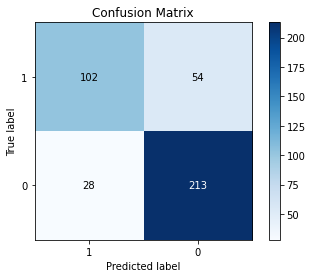

In [28]:
X_tr , X_te , y_tr , y_te = train_test_split(X_r, y_r, test_size=0.25, random_state=r_state, shuffle=True)

for cl in classifiers:
    classifier_name = cl[0]
    classifier = cl[1]
    score_eval(classifier, classifier_name, X_tr, y_tr, X_te, y_te, True)